Secara umum, berikut adalah kode untuk melakukan sentimen analysis dengan BiLSTM. Kode tersebut melibatkan beberapa tahapan dalam pemrosesan dan pelatihan model:
*   Impor pustaka dan modul: Pustaka dan modul yang diperlukan untuk pemrosesan data, visualisasi, dan pembuatan model diimpor.
*   Pengaturan awal: Beberapa pengaturan awal dilakukan, termasuk mengunduh kamus kata dasar dan daftar kata stopwords dari pustaka nltk, dan melakukan pengaturan konfigurasi untuk TensorFlow dan pandas.
*   Persiapan data: Data dibagi menjadi data latih dan data uji menggunakan modul train_test_split dari sklearn. Kemudian, teks pada data diproses dengan menggunakan tokenizer untuk mengubah teks menjadi urutan token, serta melakukan pengkodean dan pelengkapan urutan token agar memiliki panjang yang seragam.
*   Membangun model: Sebuah model sequential dari TensorFlow dibangun dengan beberapa layer seperti embedding, LSTM, bidirectional, dense, dan dropout. Model ini dirancang untuk melakukan klasifikasi teks.
*   Pelatihan model: Model tersebut dikompilasi menggunakan fungsi compile() dengan optimizer, loss function, dan metrik yang ditentukan. Selanjutnya, model dilatih dengan menggunakan fungsi fit() pada data latih. Callback early stopping digunakan untuk menghentikan pelatihan jika tidak ada peningkatan signifikan dalam performa model.
*   Evaluasi model: Setelah pelatihan selesai, model dievaluasi menggunakan metrik seperti confusion matrix dan classification report.
Secara keseluruhan, kode berikut dapat digunakan sebagai kerangka kerja umum untuk memproses data teks, membangun dan melatih model klasifikasi menggunakan TensorFlow dengan metode BiLSTM, serta mengevaluasi performa model tersebut.

### 1. Import library and load data

In [1]:
import pandas as pd
import numpy as np
import os
import re
import nltk
import random
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
np.random.seed(32)
tf.random.set_seed(32)
random.seed(32)
pd.set_option('display.max_colwidth', None)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Agar operasi TensorFlow yang deterministik

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
path='/content/drive/MyDrive/Jago Data/Sentimen Analysis - BiLSTM'

In [3]:
df=pd.read_csv(os.path.join(path,'IMDB Dataset.csv'))

In [4]:
df.sample(10)

review  \
35083                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Running only seventy-two minutes, this small, overlooked 2006 dramedy is really just a two-character sketch piece but one that works very well within its limitations. Taking place almost entirely in various, non-descript spots in southern Los Angeles, the story itself is inconsequential, but like Sofia Coppola's "Lost in Translation", the film is far more about two strangers who meet unexpectedly, find a common bond and go back to their lives enlightened for the momentous encounter. It also helps considerably that Morgan Freeman and Paz Vega are playing the characters. Finally freed of the wise sages and authority figures beyond reproach that have become his big-screen specialty, Freeman seems comparatively liberated as a somewhat self-indulgent movie star. His character is driven to a low-rent grocery store in Carson, where he will be able to research a role he is considering in an indie film.<br /><br />Out of wor

### 2. Data Preprocessing

In [5]:
# Inisialisasi lemmatizer dan stopwords
lemmatizer = WordNetLemmatizer()
STOPWORDS = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()  # Mengubah teks menjadi huruf kecil
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)  # Menghapus stopwords dari teks
    text = re.sub(r'\W', ' ', text)  # Menghapus semua karakter khusus
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Menghapus semua karakter tunggal
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)  # Menghapus karakter tunggal dari awal
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Menggantikan beberapa spasi dengan satu spasi
    # Lemmatisasi
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(tokens)
    
    return text

df['tidy_text'] = df['review'].apply(preprocess_text)

Kode di atas merupakan sebuah fungsi untuk memproses teks dengan beberapa langkah pra-pemrosesan. Pertama, dilakukan inisialisasi lemmatizer dan set stopwords yang akan digunakan. Lemmatizer digunakan untuk mengubah kata-kata dalam teks menjadi bentuk dasarnya (lematisasi), sedangkan stopwords adalah kumpulan kata-kata yang umumnya diabaikan dalam pemrosesan teks karena tidak memiliki makna khusus.

Fungsi preprocess_text menerima satu parameter, yaitu teks yang akan diproses. Pertama, teks diubah menjadi huruf kecil menggunakan metode lower() untuk konsistensi. Kemudian, dilakukan penghapusan stopwords dari teks dengan memeriksa setiap kata dalam teks menggunakan pernyataan if word not in STOPWORDS, dan menggabungkan kata-kata yang tidak termasuk dalam stopwords menggunakan metode ' '.join(word for word in text.split() if word not in STOPWORDS).

Kemudian, dilakukan penghapusan karakter khusus menggunakan regular expressions re.sub(r'\W', ' ', text), di mana \W adalah karakter non-alfanumerik. Karakter tunggal (karakter yang terpisah) dihapus menggunakan ekspresi reguler re.sub(r'\s+[a-zA-Z]\s+', ' ', text), di mana \s+ adalah satu atau lebih spasi, dan [a-zA-Z] adalah karakter alfabet. Kemudian, karakter tunggal dari awal teks dihapus dengan menggunakan ekspresi reguler re.sub(r'\^[a-zA-Z]\s+', ' ', text), di mana ^ menunjukkan awal teks.

Selanjutnya, beberapa spasi yang berurutan digantikan dengan satu spasi menggunakan regular expressions re.sub(r'\s+', ' ', text, flags=re.I). Setelah itu, dilakukan lemmatisasi pada kata-kata dalam teks. Teks dipecah menjadi token-token dengan menggunakan metode split(), kemudian setiap token diolah menggunakan lemmatizer dengan memanggil metode lemmatizer.lemmatize(token), dan hasilnya digabungkan kembali menjadi teks dengan metode ' '.join(tokens).

Terakhir, fungsi mengembalikan teks yang telah diproses. Selanjutnya, teks yang akan diproses disimpan dalam kolom 'review' dari dataframe 'df', dan hasilnya disimpan dalam kolom baru 'tidy_text' dengan menggunakan metode df['review'].apply(preprocess_text).

Berikut adalah sampel hasil data review yang telah dipreprocess sebelumnya.

In [6]:
df.sample(10)

review  \
42178                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Robert Stack never really got over losing a Best Supporting Actor Oscar for his role as Kyle in "Written on the Wind" to Anthony Quinn's 12-minute performance in "Lust for Life." Stack plays the deeply disturbed, alcoholic son of an oil tycoon. He has lived his life in the shadow of the friend with whom he was raised, Mitch, played by Rock Hudson. They both love the same woman, Lucy, (Lauren Bacall), who becomes Kyle's wife. Kyle's sister, Marylee (Dorothy Malone), is a drunken slut who's in love with Mitch. Their story plays out in glorious color under the able direction of Douglas Sirk, who really dominated the melodrama field with some incredible films, including "Imitation of Life," "All that Heaven Allows," "Magnificent Obsession," and many others.<br /><br />Make no mistake - this is a potboiler, and Stack and Dorothy Malone make the most of their roles, Malone winning a Best Supporting Actress Oscar. There's one amazing scene, mentioned in other comments, where she wildly dances to loud music as her father collapses and dies on the staircase. We're led to believe that Marylee sleeps with everyone, including the guy that pumps the gas, because she's in love with Mitch. Mitch wants nothing to do with her. He's so in love with Lucy that, out of loyalty to Kyle, he wants to go to work in Iran to avoid temptation. I doubt he'd be so anxious to get there today no matter how much in love he was.<br /><br />Hudson and Bacall have the less exciting roles here - Hudson's Mitch is the good guy who's been cleaning up Kyle's messes for his entire life, and Bacall is Mitch's wife who finds herself in a nightmare when her husband starts drinking again after a year of sobriety. Sirk focuses on the more volatile supporting players.<br /><

### 3. Explanatory Data Analysis

#### Positive Reviews

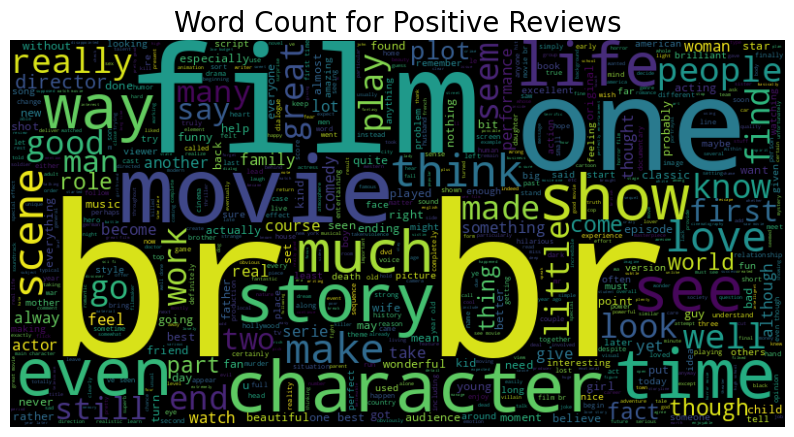

In [7]:
positive_review = df[df.sentiment == 'positive']["tidy_text"]
positive_review_string = ' '.join(positive_review)
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(max_words=1200, width=800, height=400, background_color="black").generate(positive_review_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Count for Positive Reviews", fontsize=20)
plt.show()

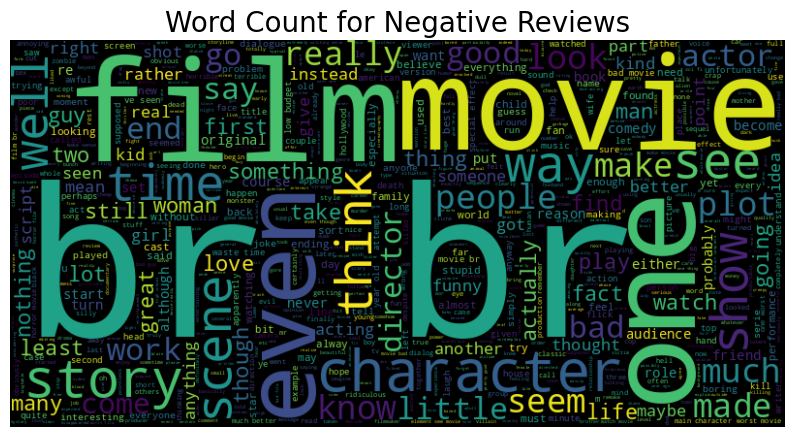

In [8]:
negative_review = df[df.sentiment == 'negative']["tidy_text"]
negative_review_string = ' '.join(negative_review)
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(max_words=1200, width=800, height=400, background_color="black").generate(negative_review_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Count for Negative Reviews", fontsize=20)
plt.show()

#### Number of characters in texts

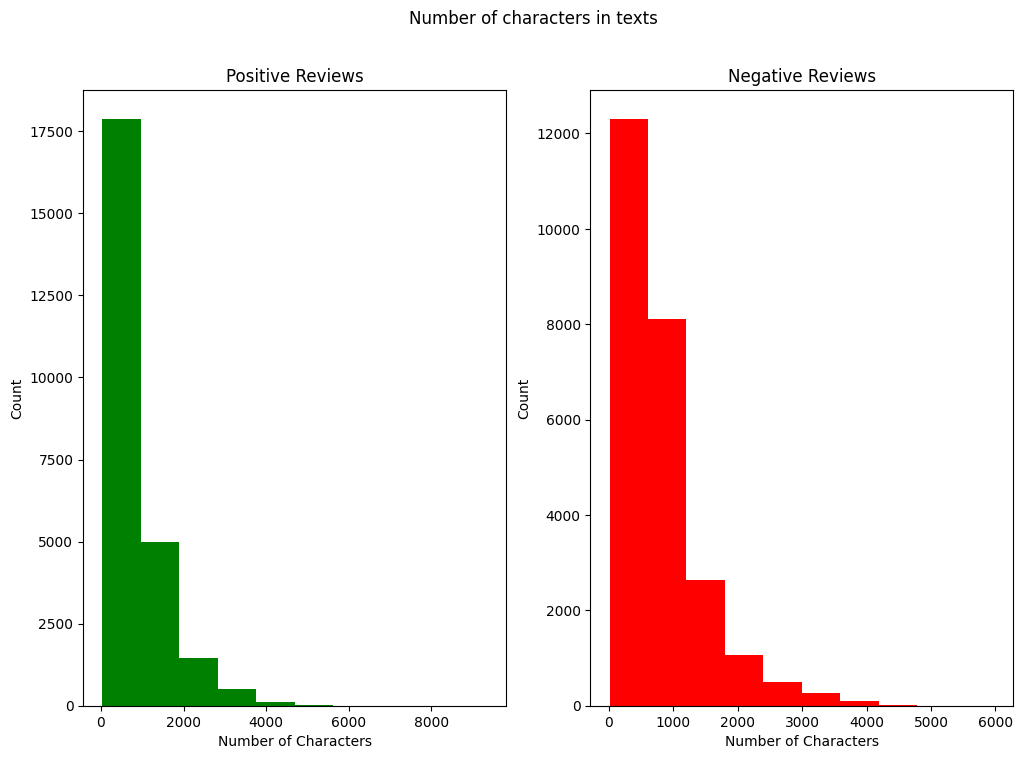

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=positive_review.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Count')
text_len=negative_review.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Count')
fig.suptitle('Number of characters in texts')
plt.show()

### 4. Tokenization and sequence **padding**

In [10]:
# Menginisialisasi Tokenizer dan mengonversi teks menjadi urutan angka
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.tidy_text)
sequences = tokenizer.texts_to_sequences(df.tidy_text)

# Mengonversi urutan menjadi sekuens dengan panjang yang sama
max_sequence_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_sequence_length)

Code di atas merupakan bagian dari pemrosesan teks menggunakan teknik Tokenization dan Padding. Berikut adalah penjelasan untuk setiap baris kode tersebut:

tokenizer = Tokenizer(): Membuat objek tokenizer dari kelas Tokenizer. Tokenizer digunakan untuk memecah teks menjadi token-token yang lebih kecil.

tokenizer.fit_on_texts(df.tidy_text): Melatih tokenizer pada teks yang disimpan dalam kolom 'tidy_text' dari dataframe 'df'. Ini menghasilkan kamus yang mengaitkan setiap kata dengan angka unik.

sequences = tokenizer.texts_to_sequences(df.tidy_text): Menggunakan tokenizer yang telah dilatih sebelumnya, mengonversi teks menjadi urutan angka. Setiap kata dalam teks diubah menjadi angka yang sesuai berdasarkan kamus yang telah dibuat sebelumnya. Hasilnya adalah urutan angka untuk setiap teks dalam dataframe.

max_sequence_length = max([len(seq) for seq in sequences]): Mencari panjang maksimum dari semua urutan angka dalam 'sequences'. Ini akan digunakan nanti saat melakukan padding.

X = pad_sequences(sequences, maxlen=max_sequence_length): Menggunakan fungsi pad_sequences dari Keras untuk mengubah urutan angka menjadi sekuens dengan panjang yang sama. Pad_sequences mengambil argumen 'sequences' yang berisi urutan angka, dan 'maxlen' yang menentukan panjang maksimum sekuens yang dihasilkan. Jika sekuens lebih pendek dari 'maxlen', akan dilakukan padding dengan nilai nol di depan sekuens. Jika sekuens lebih panjang, akan dipotong menjadi 'maxlen'.

Hasil akhirnya adalah variabel 'X' yang berisi sekuens dengan panjang yang sama setelah dilakukan tokenisasi dan padding. Variabel 'X' ini dapat digunakan sebagai input untuk model BiLSTM.

### 5. Data Splitting

In [11]:
# Converting categorical labels to numbers.
y = pd.get_dummies(df['sentiment']).values
print('Shape of label tensor:', y.shape)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

Shape of label tensor: (50000, 2)
(40000, 1476) (40000, 2)
(10000, 1476) (10000, 2)


Pada code di atas, langkah pertama adalah mengkonversi label kategorikal menjadi angka menggunakan fungsi get_dummies dari pustaka Pandas. Label kategorikal tersebut terdapat dalam kolom 'sentiment' dari DataFrame 'df'. Hasil konversi tersebut disimpan dalam variabel 'y' sebagai array numerik. Dalam hal ini, setiap label kategorikal akan diubah menjadi vektor one-hot encoding.

Setelah itu, dilakukan pemisahan data menjadi data latih (train) dan data uji (test) menggunakan fungsi train_test_split dari pustaka scikit-learn. Data yang akan dipecah adalah 'X' (fitur) dan 'y' (label). Argumen 'test_size' menentukan proporsi data uji (dalam hal ini 0.2, artinya 20% dari total data akan digunakan sebagai data uji), sedangkan 'random_state' digunakan untuk mengatur pembagian data secara acak dengan menggunakan nilai seed tertentu (dalam hal ini adalah 42).

Terakhir, dilakukan pencetakan (print) ukuran dari masing-masing data latih dan data uji. Hasilnya ditampilkan dalam format (jumlah baris, jumlah kolom) untuk masing-masing variabel X_train, y_train, X_test, dan y_test.

### 6. BiLSTM - Model Training

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1476, 100)         9215100   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                        

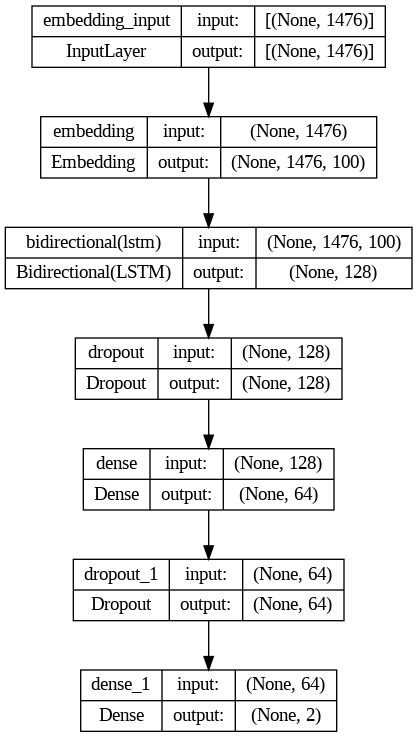

In [12]:
# Membangun model BiLSTM
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
print(model.summary())
plot_model(model, show_shapes=True)

Code di atas digunakan untuk membangun model BiLSTM (Bidirectional Long Short-Term Memory) menggunakan framework Tensorflow/Keras.

Pertama-tama, objek model Sequential dibuat sebagai wadah untuk menambahkan lapisan-lapisan model secara berurutan.

Lapisan pertama yang ditambahkan adalah lapisan Embedding. Lapisan ini bertanggung jawab untuk mengubah input teks menjadi representasi vektor. Jumlah neuron pada lapisan ini ditentukan oleh panjang (length) dari objek tokenizer.word_index, yang merupakan indeks kata-kata unik dalam dataset. Setiap kata akan direpresentasikan sebagai vektor dengan panjang 100. input_length mengacu pada panjang maksimum urutan kata dalam input.

Lapisan selanjutnya adalah lapisan Bidirectional LSTM. LSTM adalah jenis sel memori jangka panjang yang efektif dalam memproses urutan data. Dalam hal ini, LSTM dilakukan secara bidirectional, yang berarti informasi dari urutan kata dapat diproses baik ke depan maupun ke belakang. Lapisan ini memiliki 128 neuron.

Setelah lapisan LSTM, ditambahkan lapisan Dropout dengan tingkat dropout sebesar 0.3. Dropout adalah teknik yang digunakan untuk mencegah overfitting pada model dengan secara acak mengabaikan sebagian neuron dalam lapisan selama proses pelatihan.

Lapisan Dense dengan 64 neuron ditambahkan setelah lapisan Dropout. Lapisan ini bertujuan untuk menghubungkan output dari lapisan LSTM ke lapisan output.

Kemudian, ditambahkan lapisan Dropout lagi dengan tingkat dropout 0.3.

Lapisan terakhir adalah lapisan Dense dengan 2 neuron, yang menggunakan fungsi aktivasi softmax. Lapisan ini bertanggung jawab untuk menghasilkan probabilitas untuk masing-masing kelas, dalam hal ini 2 kelas (misalnya positif dan negatif).

Model yang telah dibangun kemudian dicetak (print) menggunakan model.summary() untuk menampilkan ringkasan dari model, termasuk jumlah parameter yang dapat diatur dan dimaksudkan untuk dipelajari selama proses pelatihan. Selanjutnya, plot_model() digunakan untuk menghasilkan visualisasi grafis dari model dengan menampilkan bentuk dan hubungan antara lapisan-lapisan yang ada dalam model.

In [13]:
# Compile model dengan optimizer Adam
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5, verbose = 1)
reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=2)
mcp = tf.keras.callbacks.ModelCheckpoint(filepath = 'bilstm_model_weights.h5', monitor = 'val_accuracy', 
                      save_best_only = True, verbose = 1)


# Train the model
epochs = 10
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2, callbacks=[early_stopping, reduce_lr, mcp])

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 0.5869 - accuracy: 0.7092
Epoch 1: val_accuracy improved from -inf to 0.86762, saving model to bilstm_model_weights.h5
500/500 [==============================] - 217s 423ms/step - loss: 0.5869 - accuracy: 0.7092 - val_loss: 0.3457 - val_accuracy: 0.8676 - lr: 1.0000e-04
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.2489 - accuracy: 0.9052
Epoch 2: val_accuracy improved from 0.86762 to 0.88912, saving model to bilstm_model_weights.h5
500/500 [==============================] - 158s 316ms/step - loss: 0.2489 - accuracy: 0.9052 - val_loss: 0.2654 - val_accuracy: 0.8891 - lr: 1.0000e-04
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.9442
Epoch 3: val_accuracy improved from 0.88912 to 0.89525, saving model to bilstm_model_weights.h5
500/500 [==============================] - 143s 286ms/step - loss: 0.1567 - accuracy: 0.9442 - val_loss: 0.2578 - val_accur

Pada code di atas, dilakukan kompilasi model yang telah dibangun sebelumnya menggunakan optimizer Adam.

Optimizer Adam adalah salah satu optimizer yang populer dalam pelatihan model deep learning. Pada kode tersebut, objek optimizer Adam diinisialisasi dengan learning rate sebesar 1e-4. Learning rate menentukan seberapa besar langkah yang diambil oleh optimizer saat mengupdate parameter model.

Setelah itu, model dicompile menggunakan fungsi model.compile(). Pada kompilasi ini, argumen optimizer diatur sebagai optimizer yang telah diinisialisasi sebelumnya. Loss function yang digunakan adalah 'categorical_crossentropy', yang cocok digunakan untuk masalah klasifikasi. Metrics yang digunakan untuk evaluasi model adalah akurasi ('accuracy').

Selanjutnya, beberapa callback digunakan selama proses pelatihan model. Callback EarlyStopping digunakan untuk menghentikan proses pelatihan jika terjadi overfitting. Monitor 'loss' digunakan untuk melacak penurunan loss pada setiap epoch, dan jika tidak ada perubahan yang signifikan dalam 5 epoch berurutan, proses pelatihan akan dihentikan. Callback ReduceLROnPlateau digunakan untuk mengurangi learning rate jika terjadi stagnasi dalam peningkatan validation loss. Callback ModelCheckpoint digunakan untuk menyimpan bobot model yang memberikan performa terbaik pada validation accuracy. File bobot model akan disimpan dengan nama 'bilstm_model_weights.h5'.

Selanjutnya, proses pelatihan model dilakukan dengan menggunakan fungsi model.fit(). Dalam hal ini, data latih (X_train dan y_train) digunakan sebagai input. Jumlah epoch yang ditentukan adalah 10, dan ukuran batch adalah 64. Validation split sebesar 0.2 menandakan bahwa 20% dari data latih akan digunakan sebagai data validasi. Callbacks yang telah ditentukan sebelumnya juga diberikan sebagai argumen untuk melacak dan mengontrol proses pelatihan.

Selama proses pelatihan, informasi tentang loss dan metrik lainnya akan disimpan dalam objek history untuk analisis selanjutnya.

### 7. Model Evaluation

In [14]:
def plot_learning_curves(history, model_name):
    metrics =  ['loss', 'precision', 'recall','accuracy']
    train_acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']
    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(train_acc, '-o',label='Train Acc.')
    ax.plot(val_acc, '--<', color='orange', label='Validation Acc.')
    ax.set_title("Training-Validation Accuracy",size=12)
    ax.legend(loc='best',fontsize=12)
    ax.set_xlabel('Epoch', size=12)
    ax.set_ylabel('Accuracy', size=12)
    ax.set_xticks(np.arange(0, len(train_acc)+5, 5))
    ax.set_yticks(np.arange(0.1,1.05,0.1))
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(train_loss,'-o', label='Train Loss')
    ax.plot(val_loss,'--<', color='orange',  label='Validation Loss')
    ax.set_title("Train-Validation Loss",size=12)
    ax.legend(loc='best',fontsize=12)
    ax.set_xlabel('Epoch', size=12)
    ax.set_ylabel('Loss', size=12)
    ax.set_xticks(np.arange(0, len(train_acc)+5, 5))
    ax.set_yticks(np.arange(0,3.5,0.5))
    plt.savefig('Learning Curves {}.png'.format(model_name))
    plt.title(f'Learning Curves')
    plt.show()

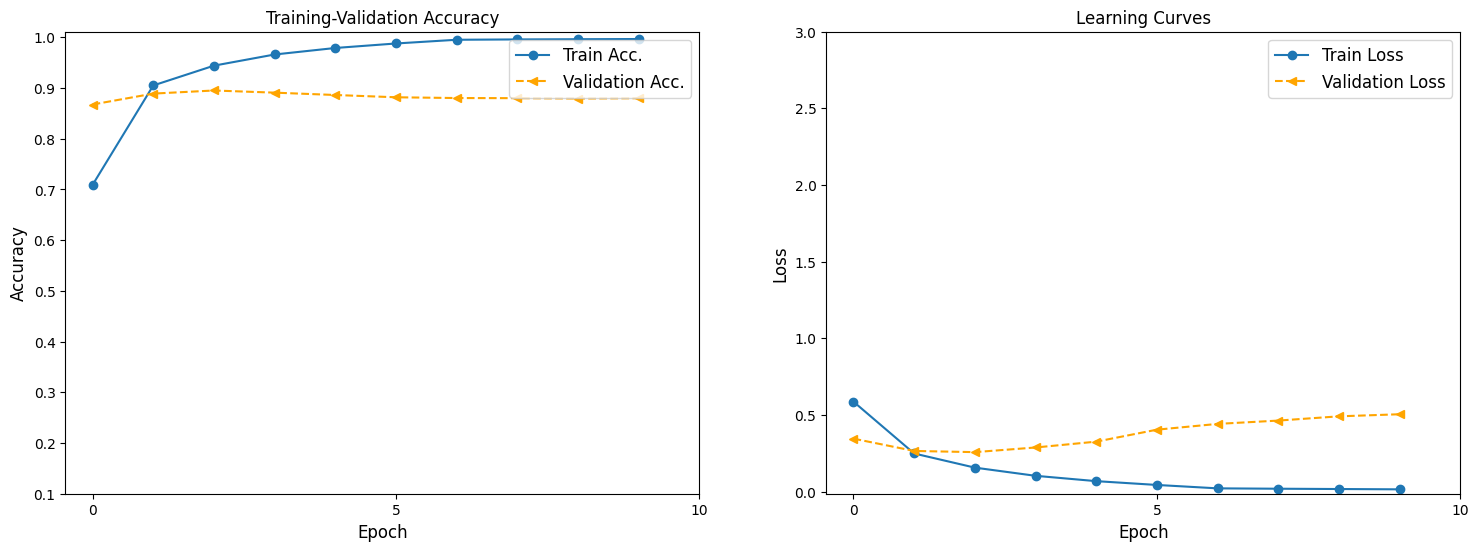

In [15]:
plot_learning_curves(history, "BiLSTM")

Fungsi plot_learning_curves di atas digunakan untuk menghasilkan visualisasi dari kurva pembelajaran (learning curves) yang menunjukkan perubahan akurasi dan loss selama proses pelatihan model.

Fungsi ini memiliki dua parameter:

* history: Objek history yang berisi informasi tentang loss dan metrik lainnya yang telah direkam selama proses pelatihan model.
* model_name: Nama model yang akan digunakan sebagai judul dan nama file gambar hasil visualisasi.
Pada awal fungsi, beberapa metrik yang akan ditampilkan dalam kurva pembelajaran diinisialisasi, yaitu 'loss', 'precision', 'recall', dan 'accuracy'. Kemudian, nilai loss, akurasi (train dan validation), dan val_loss direkam dari objek history.

Fungsi menggunakan modul matplotlib untuk membuat gambar dan kurva pembelajaran. Dalam kode tersebut, terdapat inisialisasi objek fig dengan ukuran gambar 18x6. Terdapat juga dua subplot dalam gambar, diatur dengan fig.add_subplot(1, 2, 1) dan fig.add_subplot(1, 2, 2).

Pada subplot pertama, dilakukan plotting kurva akurasi dengan memplot train_acc dan val_acc menggunakan garis solid ('-o') dan '--<' dengan warna oranye. Judul subplot diatur sebagai "Training-Validation Accuracy". Legend dan label sumbu x dan y ditambahkan untuk memberikan informasi tentang kurva. Posisi ticks juga diatur untuk sumbu x dan y.

Pada subplot kedua, dilakukan plotting kurva loss dengan memplot train_loss dan val_loss menggunakan garis solid ('-o') dan '--<' dengan warna oranye. Judul subplot diatur sebagai "Train-Validation Loss". Legend dan label sumbu x dan y ditambahkan. Posisi ticks juga diatur untuk sumbu x dan y.

Setelah plotting selesai, gambar disimpan sebagai file gambar dengan nama "Learning Curves {model_name}.png" menggunakan plt.savefig(). Kemudian, gambar ditampilkan menggunakan plt.show().

Dengan menggunakan fungsi plot_learning_curves, kita dapat memvisualisasikan kurva pembelajaran model untuk melihat bagaimana akurasi dan loss berubah selama proses pelatihan.

313/313 [==============================] - 21s 60ms/step


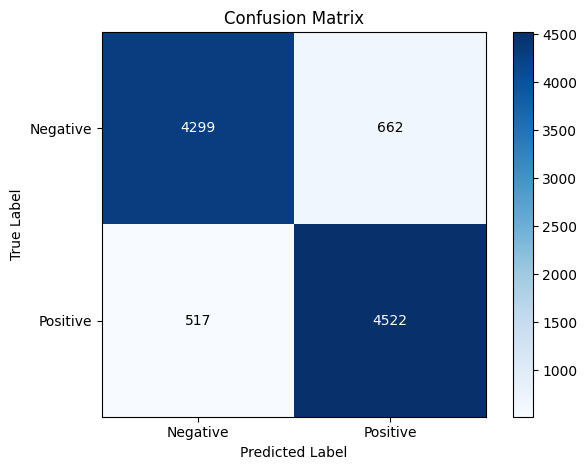

              precision    recall  f1-score   support

    Negative       0.89      0.87      0.88      4961
    Positive       0.87      0.90      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [16]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Menampilkan confusion matrix
labels = ['Negative', 'Positive']
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
       xticklabels=labels, yticklabels=labels, title='Confusion Matrix',
       ylabel='True Label', xlabel='Predicted Label')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
# Menampilkan plot
plt.show()

# Menampilkan classification report
target_names = ['Negative', 'Positive']
print(classification_report(y_true, y_pred, target_names=target_names))

Code di atas digunakan untuk melakukan evaluasi model pada data uji dan menampilkan metrik evaluasi seperti confusion matrix dan classification report.

Pertama-tama, dilakukan prediksi terhadap data uji menggunakan model yang telah dilatih sebelumnya. Hasil prediksi tersebut disimpan dalam variabel y_pred. Karena output model adalah probabilitas untuk setiap kelas, menggunakan fungsi np.argmax dengan axis=1 dilakukan untuk mendapatkan label kelas yang diprediksi secara final.

Selanjutnya, label sebenarnya (y_true) untuk data uji juga diambil dengan menggunakan np.argmax dengan axis=1.

Kemudian, dilakukan perhitungan confusion matrix dengan membandingkan y_true dan y_pred menggunakan confusion_matrix dari scikit-learn.

Confusion matrix tersebut kemudian ditampilkan dalam bentuk plot dengan menggunakan modul matplotlib. Disini, terdapat pengaturan warna menggunakan cmap=plt.cm.Blues, label sumbu x dan y menggunakan labels, judul plot, dan penambahan teks pada setiap sel dalam confusion matrix.

Setelah itu, dilakukan tampilan classification report yang berisi metrik evaluasi seperti precision, recall, f1-score, dan support untuk setiap kelas. classification_report dari scikit-learn digunakan untuk menghasilkan laporan tersebut dengan menyertakan y_true, y_pred, dan target_names.

Terakhir, hasil confusion matrix dan classification report ditampilkan menggunakan fungsi plt.show() dan print().

Berikut adalah penjelasan untuk setiap metrik dalam classification report yang diberikan:

1. Precision: Precision mengukur sejauh mana model dapat mengidentifikasi dengan benar kelas yang diinginkan. Precision dihitung dengan membagi jumlah true positives (positif yang benar) dengan jumlah total prediksi positif (true positives + false positives). Dalam contoh ini, untuk kelas "Negative", precision-nya adalah 0.89, yang berarti model memiliki tingkat keakuratan yang baik dalam mengklasifikasikan sampel-sampel sebagai "Negative". Untuk kelas "Positive", precision-nya adalah 0.87, menunjukkan bahwa model juga memiliki tingkat keakuratan yang baik dalam mengklasifikasikan sampel-sampel sebagai "Positive".

2. Recall: Recall (juga dikenal sebagai sensitivity atau true positive rate) mengukur sejauh mana model dapat menemukan semua sampel yang sebenarnya termasuk dalam suatu kelas. Recall dihitung dengan membagi jumlah true positives dengan jumlah true positives ditambah false negatives. Dalam contoh ini, untuk kelas "Negative", recall-nya adalah 0.86, artinya model mampu mengidentifikasi 86% dari semua sampel sebenarnya yang termasuk dalam kelas "Negative". Untuk kelas "Positive", recall-nya adalah 0.90, menunjukkan bahwa model mampu menemukan 90% dari semua sampel sebenarnya yang termasuk dalam kelas "Positive".

3. F1-score: F1-score adalah ukuran rata-rata harmonis antara precision dan recall. F1-score menyediakan keseimbangan antara precision dan recall, dan berguna ketika kita ingin mengevaluasi kualitas keseluruhan dari sebuah model. F1-score dihitung dengan rumus 2 * (precision * recall) / (precision + recall). Dalam contoh ini, kedua kelas, "Negative" dan "Positive", memiliki f1-score yang sama yaitu 0.88, yang menunjukkan keseimbangan yang baik antara precision dan recall untuk kedua kelas tersebut.

4. Support: Support adalah jumlah sampel yang ada dalam setiap kelas. Dalam contoh ini, jumlah sampel untuk kelas "Negative" adalah 4961, sedangkan jumlah sampel untuk kelas "Positive" adalah 5039.

5. Accuracy: Akurasi mengukur sejauh mana model dapat mengklasifikasikan secara benar seluruh sampel dalam dataset. Akurasi dihitung dengan membagi jumlah prediksi yang benar (true positives + true negatives) dengan jumlah total sampel. Dalam contoh ini, akurasi model adalah 0.88 atau 88%, yang berarti model secara keseluruhan mengklasifikasikan 88% dari seluruh sampel dengan benar.

In [17]:
model.save(os.path.join(path,'model_BiLSTM.h5'))

In [19]:
import pickle

# Menyimpan tokenizer ke file
tokenizer_filename = "tokenizer.pkl"
with open(os.path.join(path,tokenizer_filename), 'wb') as file:
    pickle.dump(tokenizer, file)